In [158]:
%load_ext lab_black

In [2]:
import os
import sys

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import xarray as xr
from cmcrameri import cm
from hydra import compose, initialize
from omegaconf import OmegaConf, DictConfig
from scipy.optimize import differential_evolution
from sklearn import preprocessing
import seaborn as sns

sys.path.append("../")
import matplotlib_functions as mympf
from cfg.convert_cfg_to_yaml import save_myyaml_from_mycfg
from Data import Data_eval
from include.loss import pixel_weighted_cross_entropy
import model_eval
import models.reg as rm


import matplotlib_functions as mympf

mympf.setMatplotlibParam()
plt.viridis()

dir_res = "/cerea_raid/users/dumontj/dev/coco2/dl/res"

<Figure size 1920x1440 with 0 Axes>

In [169]:
ds = xr.open_dataset("/libre/dumontj/coco2/dl-input/2km_Lip/train_dataset.nc")

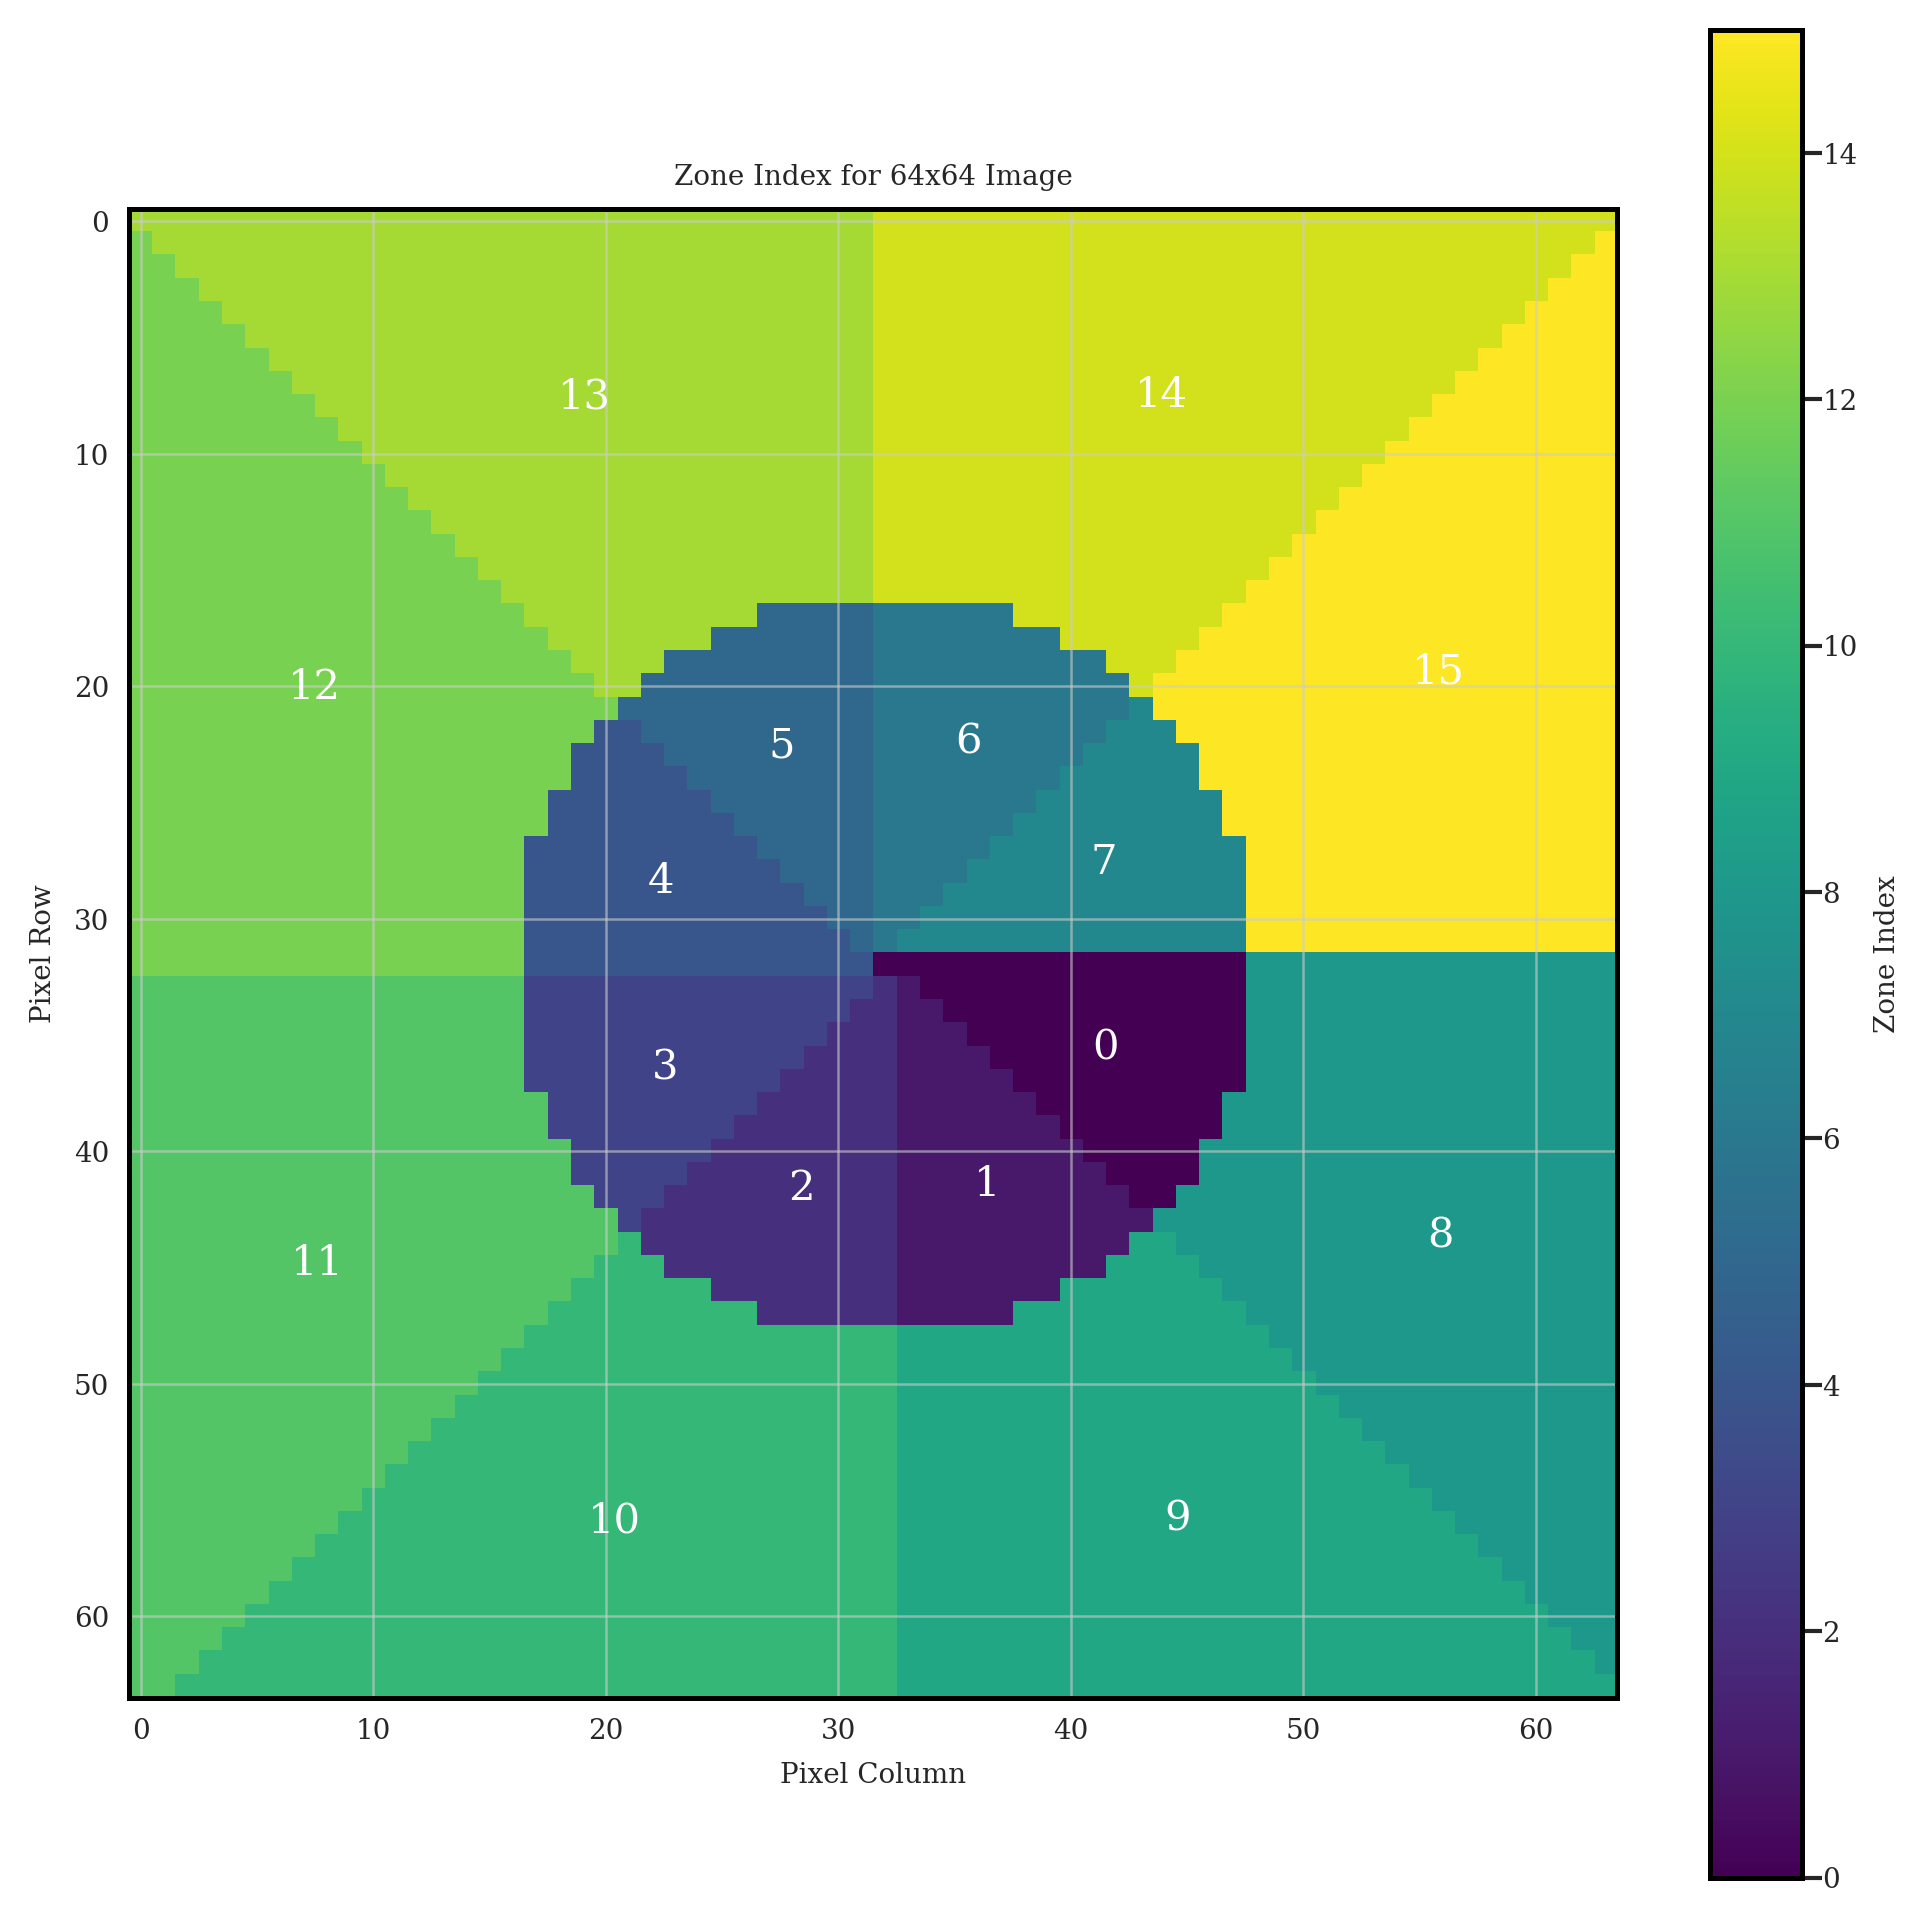

In [171]:
import numpy as np
import matplotlib.pyplot as plt


def get_area(x, y):
    """
    Returns the area index for a given pixel coordinates (x, y) in a 64x64 image
    based on its radius and angle to the center of the image.
    """
    center_x, center_y = 32, 32
    radius = np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2)
    angle = np.degrees(np.arctan2(y - center_y, x - center_x)) % 360
    return np.where(
        radius < 16,
        np.where(
            angle < 45,
            0,
            np.where(
                angle < 90,
                1,
                np.where(
                    angle < 135,
                    2,
                    np.where(
                        angle < 180,
                        3,
                        np.where(
                            angle < 225,
                            4,
                            np.where(angle < 270, 5, np.where(angle < 315, 6, 7)),
                        ),
                    ),
                ),
            ),
        ),
        np.where(
            angle < 45,
            8,
            np.where(
                angle < 90,
                9,
                np.where(
                    angle < 135,
                    10,
                    np.where(
                        angle < 180,
                        11,
                        np.where(
                            angle < 225,
                            12,
                            np.where(
                                angle < 270,
                                13,
                                np.where(angle < 315, 14, np.where(angle < 360, 15, 8)),
                            ),
                        ),
                    ),
                ),
            ),
        ),
    )


# create a 64x64 image
x, y = np.meshgrid(np.arange(64), np.arange(64))
zone = get_area(x, y).astype(int)

# set up the figure
fig, ax = plt.subplots(figsize=(8, 8))

# plot the zones with their corresponding labels
im = ax.imshow(zone)
for i in range(16):
    x, y = np.where(zone == i)
    if len(x) > 0:
        ax.text(
            np.mean(y),
            np.mean(x),
            str(i),
            color="w",
            ha="center",
            va="center",
            fontsize=10,
        )

# set up the colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Zone Index")

# set up the axis labels and title
ax.set_xlabel("Pixel Column")
ax.set_ylabel("Pixel Row")
ax.set_title("Zone Index for 64x64 Image")
plt.show()

In [172]:
def get_zone_proportions(image):
    zone_values = np.zeros((16,))
    for z in range(16):
        zone_values[z] = np.mean(image[zone == z])

    # calculate the proportion of values in each zone
    total_values = np.sum(image)
    zone_proportions = np.zeros((16,))
    for z in range(16):
        zone_proportions[z] = np.sum(image[zone == z]) / total_values
    return zone_proportions

In [173]:
zone_proportions = get_zone_proportions(plume)
zone_proportions

array([0.4894326 , 0.01329798, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.49726936, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

In [174]:
top_zones_indices = np.argsort(zone_proportions)[::-1][:3]
print(top_zones_indices)

[8 0 1]


In [175]:
def get_zone_proportions_all_images(all_images):
    zone_proportions_all = np.zeros((all_images.shape[0], 16))

    for i in range(all_images.shape[0]):
        image = all_images[i]
        x, y = np.meshgrid(np.arange(64), np.arange(64))
        zone = get_area(x, y).astype(int)
        zone_values = np.zeros((16,))

        for z in range(16):
            zone_values[z] = np.mean(image[zone == z])

        total_values = np.sum(image)
        zone_proportions = np.zeros((16,))

        for z in range(16):
            zone_proportions[z] = np.sum(image[zone == z]) / total_values

        zone_proportions_all[i] = zone_proportions

    return zone_proportions_all

In [176]:
zp = get_zone_proportions_all_images(ds.plume.values)

/tmp/ipykernel_2648713/2396717517.py:17: RuntimeWarning: invalid value encountered in float_scalars
  zone_proportions[z] = np.sum(image[zone == z]) / total_values


In [177]:
cur_zp = zp[104]
print(cur_zp)
top_zones_indices = np.argsort(cur_zp)[::-1][:3]
print(top_zones_indices)

[0.36436385 0.14284657 0.00624301 0.         0.         0.
 0.         0.         0.48654661 0.         0.         0.
 0.         0.         0.         0.        ]
[8 0 1]


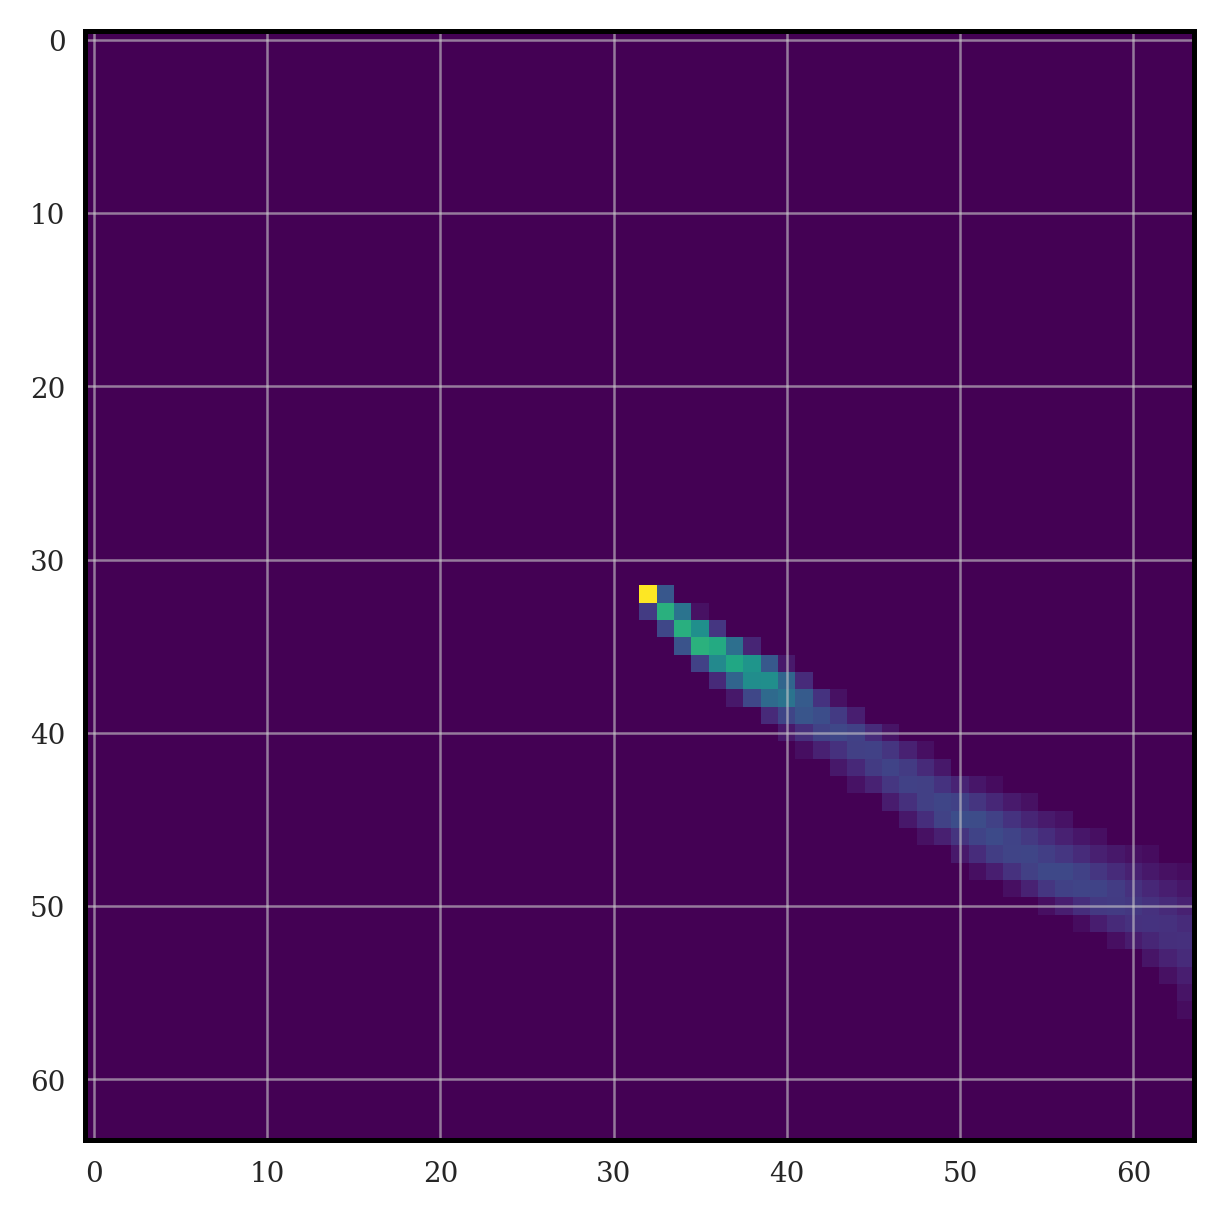

In [178]:
plt.imshow(ds.plume.values[104])

In [179]:
def calc_var_explained(zones_proportions_all):
    var_explained = np.zeros((len(zones_proportions_all),))
    for i, zones_proportions in enumerate(zones_proportions_all):
        sorted_props = np.sort(zones_proportions)[::-1]
        var_explained[i] = np.sum(sorted_props[:3]) / np.sum(sorted_props)
    return var_explained


var = calc_var_explained(zp)

In [180]:
def calc_zones_needed(zones_proportions_all):
    zones_needed = np.zeros((len(zones_proportions_all),))
    for i, zones_proportions in enumerate(zones_proportions_all):
        sorted_props = np.sort(zones_proportions)[::-1]
        cumsum_props = np.cumsum(sorted_props)
        idx = np.argmax(cumsum_props >= 0.9)
        zones_needed[i] = idx + (idx == 0)

    return zones_needed + 1


zones_needed = calc_zones_needed(zp)

In [181]:
def get_zone_aligns(zones_proportions_all):
    aligns = np.zeros((zones_proportions_all.shape[0], 1))
    for i, zp in enumerate(zones_proportions_all):
        sorted_indices = np.argsort(zp)[::-1]
        if np.abs(sorted_indices[0] - sorted_indices[1]) == 8:
            aligns[i] = 1
    return aligns


aligns = get_zone_aligns(zp)

In [182]:
ds_stat = xr.Dataset(
    {
        "align_bool": (["idx_img"], np.squeeze(aligns)),
        "mass_in3zones": (["idx_img"], np.squeeze(var)),
        "Nzones_for90p": (["idx_img"], np.squeeze(zones_needed)),
    },
    coords={"idx_img": range(ds.attrs["N_img"])},
)

In [183]:
ds_stat

<xarray.Dataset>
Dimensions:        (idx_img: 6289)
Coordinates:
  * idx_img        (idx_img) int64 0 1 2 3 4 5 ... 6283 6284 6285 6286 6287 6288
Data variables:
    align_bool     (idx_img) float64 0.0 0.0 1.0 1.0 1.0 ... 1.0 1.0 0.0 0.0 1.0
    mass_in3zones  (idx_img) float64 nan 0.9971 0.9433 ... 0.8066 0.8071 0.858
    Nzones_for90p  (idx_img) float64 2.0 2.0 3.0 2.0 2.0 ... 2.0 3.0 4.0 4.0 4.0

In [185]:
os.remove("/libre/dumontj/coco2/dl-input/2km_Lip/stats.nc")
ds_stat.to_netcdf("/libre/dumontj/coco2/dl-input/2km_Lip/stats.nc")